# "Hallelujah Effect" Principal Components Analysis

This notebook performs a PCA analysis of the variables included in previous "Hallelujah Effect" analyses. these variables include all basic features available in the dataset for those subjects that listened to the song and had an EDA quality >80% using various SVM models.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [2]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [3]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [4]:
# Set credentials as necessary to use Google Cloud Platform
import os

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/paperspace/gcloud_service_account_key.json'

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Data in BigQuery has been pre-processed with Dataprep. This helper function returns data from the dataset *with imputed values*.

In [6]:
def create_query(phase, EVERY_N):
    """
    phase: 1=train 2=valid
    """

    base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned_imputed`
    """
    if EVERY_N == None:
        if phase < 2:
            # Training
            query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
        else:
            # Validation
            query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
    else:
        query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
    return query

Build a dataset of all observations.

In [7]:
from google.cloud import bigquery as bq

client = bq.Client()
df_all_query = create_query(0, 1)
df_all = client.query(df_all_query).to_dataframe()
df_all.head()
df_all.describe()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.00000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.00000,364.000000,364.000000,364.000000
mean,24.607143,3.991266,0.060440,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.22807,...,0.008242,0.134615,0.192308,0.134615,0.428571,0.678571,0.31044,0.178571,0.082418,0.060440
std,13.540961,0.795965,0.238627,1.004845,0.962591,0.887972,0.838112,0.914277,0.873354,0.94787,...,0.090534,0.341782,0.394656,0.341782,0.495553,0.467668,0.46331,0.383520,0.275378,0.238627
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,16.000000,3.991266,0.000000,2.000000,2.000000,3.000000,3.824561,3.659389,3.596491,3.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,0.000000,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.22807,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000
75%,31.000000,4.000000,0.000000,3.000000,2.353712,4.000000,4.000000,4.000000,4.000000,4.00000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000
max,121.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Create a helper function to preprocess the dataset.

In [8]:
def preprocess_df(df, scaling_dict=None):
    """
    Preprocess a dataframe for this analysis.

    If a scaling dict is provided, columns are scaled between 0 and 1. If a scaling
    dict is provided, each column name in the dataframe should have a key in the 
    scaling dict with the same name. The value of this key should itself be a dict
    with 'min' and 'max' keys.

    If no scaling dict is provided, one is calculated and returned in the response. 
    This scaling dict can then be used in transforming another dataset (for example,
    to apply the same transformation to an evaluation dataset that was used in scaling 
    a training dataset).
    """
    import numpy as np
    import pandas as pd

    updated_df = df.drop(labels=['id', 'hallelujah_reaction'], axis=1)

    updated_df = pd.concat(
        [
            updated_df.drop(labels=['location', 'nationality', 'sex', 'language'], axis=1), 
            pd.get_dummies(updated_df['location'], prefix='location'),
            pd.get_dummies(updated_df['nationality'], prefix='nationality'),
            pd.get_dummies(updated_df['sex'], prefix='sex'),
            pd.get_dummies(updated_df['language'], prefix='language')
        ], 
        axis=1
    )

    updated_df = updated_df.apply(pd.to_numeric)

    if scaling_dict is None:
        scaling_dict = {}
    
    for column in updated_df.columns:
        scaling_dict[column] = {
            'max': updated_df[column].max(),
            'min': updated_df[column].min()
        }

    for column in updated_df.columns:
        if column not in scaling_dict.keys():
            updated_df = updated_df.drop(labels=[column], axis=1)
        else:
            updated_df[column] = np.subtract(updated_df[column], scaling_dict[column]['min'], dtype=np.float32)
            updated_df[column] = updated_df[column] / np.subtract(scaling_dict[column]['max'], scaling_dict[column]['min'], dtype=np.float32)

    return updated_df, scaling_dict

## PCA

Compute a PCA on the dataset containing all observations.

In [9]:
from sklearn.decomposition import PCA

df_all_X, _ = preprocess_df(df_all)

In [10]:
pca = PCA(n_components=df_all_X.shape[1], random_state=RANDOM_STATE)
pca = pca.fit(df_all_X)

Save PCA results into their own dataframe.

In [11]:
import pandas as pd
import numpy as np

pca_df_dict = {}

for i, ratio in enumerate(pca.explained_variance_ratio_):
    pca_df_dict[i] = pca.components_[i]
    
pca_df = pd.DataFrame(pca_df_dict, columns=np.arange(len(pca.components_)), index=df_all_X.columns)
pca_df = pca_df.transpose()
pca_df.head()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,nationality_japanese,nationality_other,nationality_singaporean,nationality_taiwanese,nationality_thai,sex_female,sex_male,language_NA,language_en,language_zh_TW
0,0.027214,-0.006117,0.022137,0.019922,0.000469,0.003385,-0.000952,-0.006935,-0.005909,-0.002103,...,-0.002129,0.110670,-0.002007,-0.382073,-0.001106,-0.081069,0.081069,0.393460,-0.332057,-0.061404
1,-0.012349,0.001343,-0.033402,0.006548,0.047492,0.015865,0.013737,-0.038029,-0.027129,0.004714,...,-0.004891,-0.031784,0.008813,0.016374,0.004954,-0.668648,0.668648,-0.046718,-0.023203,0.069921
2,0.012655,0.038095,-0.007372,0.102547,-0.069712,0.053053,0.066300,0.098677,-0.001901,0.002568,...,0.001405,-0.000872,-0.004662,0.044867,-0.003360,-0.042778,0.042778,-0.049974,0.139777,-0.089803
3,-0.023439,0.043555,-0.000634,-0.024490,0.046904,0.020834,0.029422,0.068530,0.084556,0.052770,...,-0.020539,-0.007230,-0.010370,0.081660,0.002847,-0.085026,0.085026,-0.007534,0.014707,-0.007173
4,-0.002396,-0.088212,-0.021456,-0.027502,-0.057996,-0.023087,-0.062544,-0.031236,0.008378,-0.059087,...,0.001707,-0.001646,0.004493,0.091053,-0.014958,-0.096579,0.096579,-0.063935,0.427843,-0.363908


Sort columns of dataframe to aid in visualization.

In [12]:
rearranged_columns = [
    'age',
    'hearing_impairments',
    'sex_female',
    'sex_male',
    'location_dublin',
    'location_taichung_city',
    'location_taipei_city',
    'nationality_american',
    'nationality_british',
    'nationality_chinese',
    'nationality_indonesian',
    'nationality_irish',
    'nationality_japanese',
    'nationality_other',
    'nationality_singaporean',
    'nationality_taiwanese',
    'nationality_thai',
    'language_NA',
    'language_en',
    'language_zh_TW',
    'musical_expertise',
    'music_pref_none',
    'music_pref_hiphop',
    'music_pref_dance',
    'music_pref_world',
    'music_pref_rock',
    'music_pref_pop',
    'music_pref_classical',
    'music_pref_jazz',
    'music_pref_folk',
    'music_pref_traditional_irish',
    'concentration',
    'artistic',
    'fault',
    'imagination',
    'lazy',
    'nervous',
    'outgoing',
    'reserved',
    'stress',
    'thorough',
    'trusting',
    'activity',
    'engagement',
    'familiarity',
    'like_dislike',
    'positivity',
    'tension'
]

pca_df = pca_df[rearranged_columns]

Create a parallel coordinates plot of the first five components from PCA.

In [13]:
def correct_label(s):
    prefixes = [
        'Nationality',
        'Sex',
        'Language',
    ]
    s = s.replace('_', ' ')
    s = s.title()
    s = s.split(' ')
    if s[0] in prefixes:
        s[0] = s[0] + ':'
    if s[0] == 'Music' and s[1] == 'Pref':
        s[1] = s[1] + ':'
    
    joined = ' '.join(s)
    
    if joined == 'Language: En':
        joined = 'Language: English'
    elif joined == 'Language: Zh Tw':
        joined = 'Language: Taiwanese'
    elif joined == 'Language: Na':
        joined = 'Language: N/A'
    return joined

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


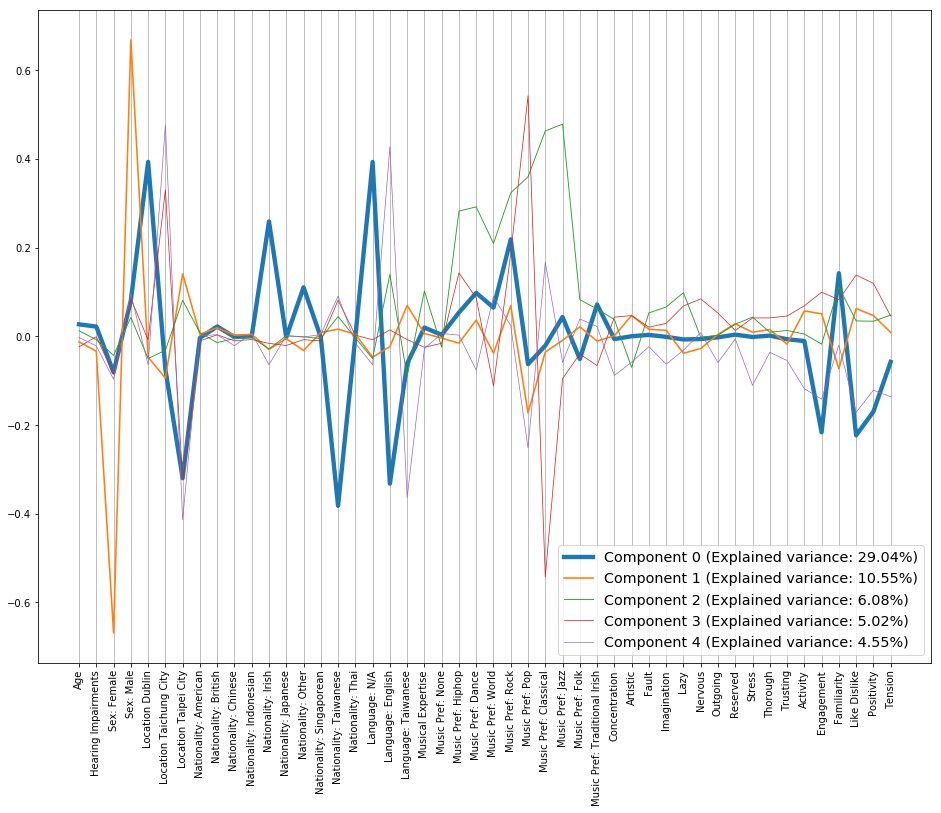

In [14]:
plt.figure(figsize=(16,12))

for i, row in list(pca_df.iterrows())[0:5]:
    explained_variance = pca.explained_variance_ratio_[i]
    plt.plot(np.arange(len(row)), row, linewidth=explained_variance * 15, label='Component {} (Explained variance: {:.2%})'.format(i, explained_variance))

plt.xticks(np.arange(len(pca_df.columns)), pca_df.columns, rotation=90)

xticks, xlabels = plt.xticks()
[xlabel.set_text(correct_label(xlabel.get_text())) for xlabel in xlabels]
plt.xticks(xticks, xlabels)

old_params = dict(plt.rcParams)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.grid(which='both', axis='x')
plt.legend()
plt.savefig('hallelujah_reaction_pca_loadings.pdf');

plt.rcParams.update(old_params)

Transform original data based on PCA.

In [15]:
# Transform original data
df_all_transformed_X = pca.fit_transform(df_all_X)

df_all_transformed_X.shape

df_all_transformed = pd.concat([pd.DataFrame(df_all_transformed_X), df_all.hallelujah_reaction], axis=1)
df_all_transformed = df_all_transformed.rename(index=str, columns={'hallelujah_reaction': 'Reaction'})
df_all_transformed['Reaction'] = df_all_transformed['Reaction'].astype('bool')

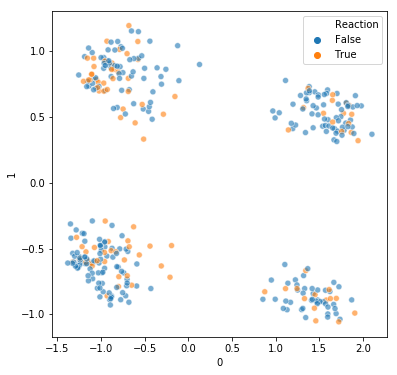

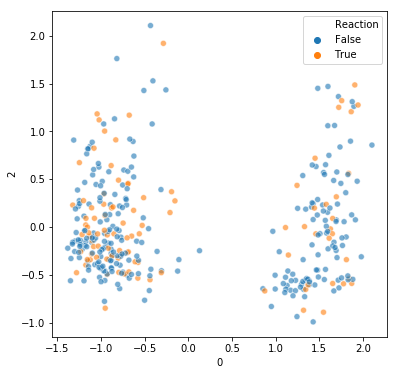

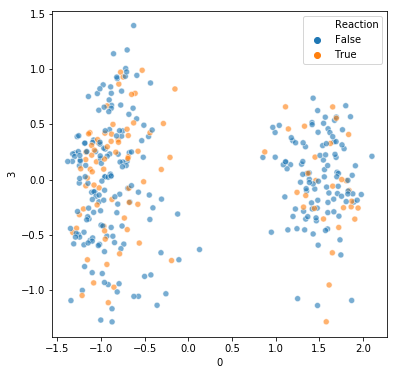

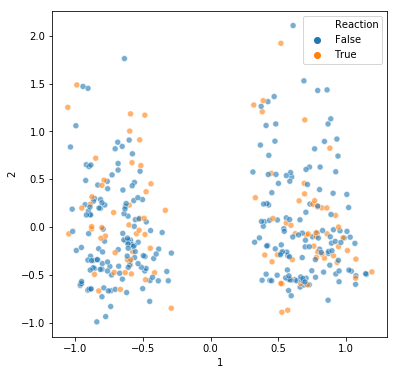

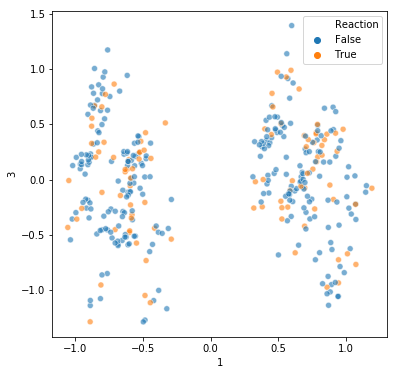

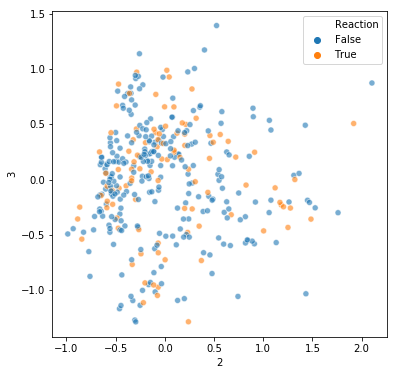

In [16]:
import itertools
for x_idx, y_idx in itertools.combinations(np.arange(4), 2):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x_idx, y_idx, data=df_all_transformed, hue='Reaction', alpha=0.6)
    plt.savefig(f'hallelujah_reaction_pca_scatter_{x_idx}_{y_idx}.pdf')

Inspect variance explained by most prominent components.

In [17]:
pd.DataFrame(pca.explained_variance_ratio_)[:10]

,0
0,0.290439
1,0.105488
2,0.060830
3,0.050235
4,0.045502
5,0.041401
6,0.037004
7,0.033294
8,0.031789
9,0.026656


In [18]:
# Variance explained by first ten components

pd.DataFrame(pca.explained_variance_ratio_)[:10].sum()

0    0.722637
dtype: float64

Visualize each component on a radial plot.

In [19]:
def plot_component(df_pca, component_no, var_ratios):
    from math import pi
    
    df = df_pca.T.copy()

    # Number of variables
    categories=list(df)[1:]
    N = len(categories)

    # Rename index to remove explained variance percentages and take
    # absolute value of each cell
    df.index = np.arange(len(df.index)) + 1
    df = df.abs()

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N + 1)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(14,14))
    ax = plt.subplot(111, polar=True, )

    # Draw one axis per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    ytick_positions = np.linspace(0, 0.75, 16)
    ytick_labels = [str(x) for x in ytick_positions]
    plt.yticks(ytick_positions, ytick_labels, color="grey", size=7)
    plt.ylim(0,0.75)

    if type(component_no) is int:
        components = [component_no]
        title = 'Loadings for Component {}\nExplained Variance: {:4.2f}%'.format(component_no, var_ratios[component_no - 1] * 100)
    else:
        components = component_no
        component_names = ', '.join(map(str, components))
        total_var = sum([var_ratios[component - 1] for component in components]) * 100
        title = 'Loadings for Components {}\nExplained Variance: {:4.2f}%'.format(component_names, total_var)
        
    for component in components:
        
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values=df.loc[component].values.flatten().tolist()
        values += values[:1]

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')

        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)
    
    # Add title
    plt.title(title)

    plt.tight_layout()

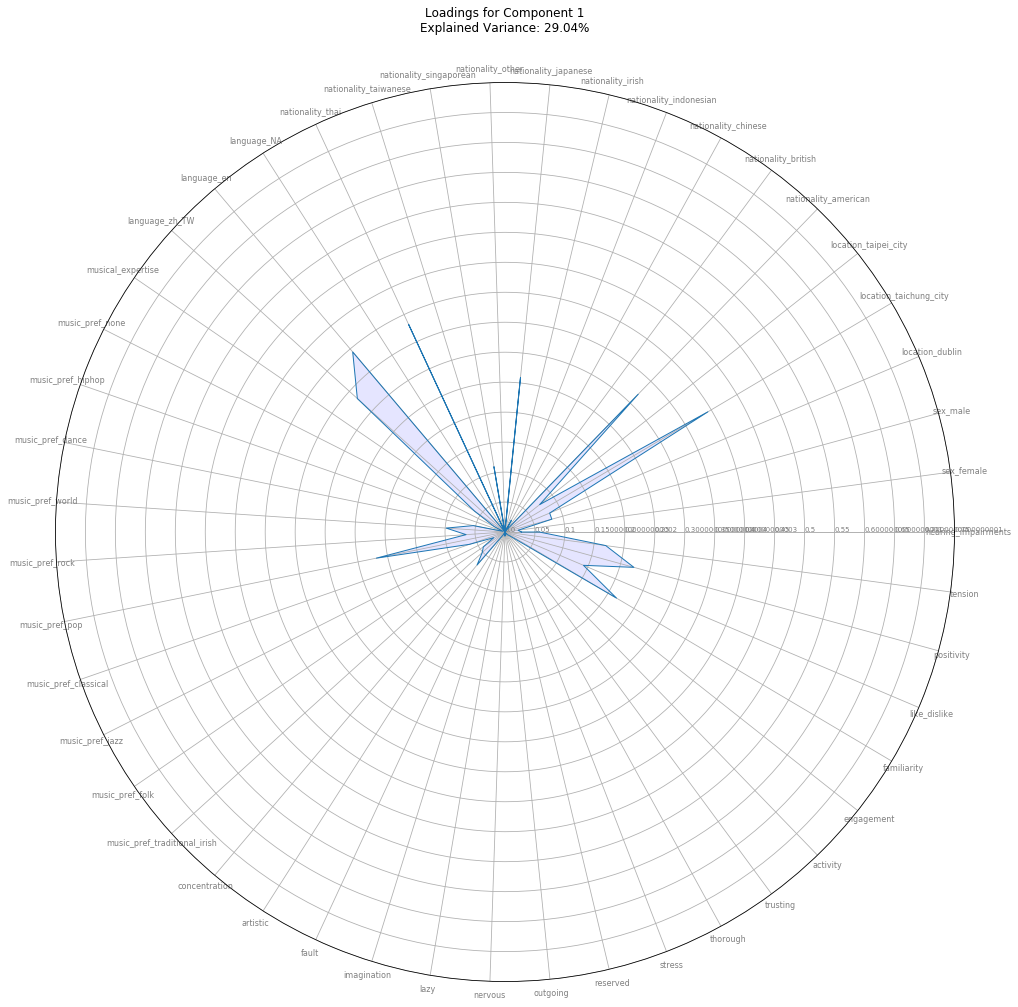

In [20]:
plot_component(pca_df.T, 1, pca.explained_variance_ratio_)

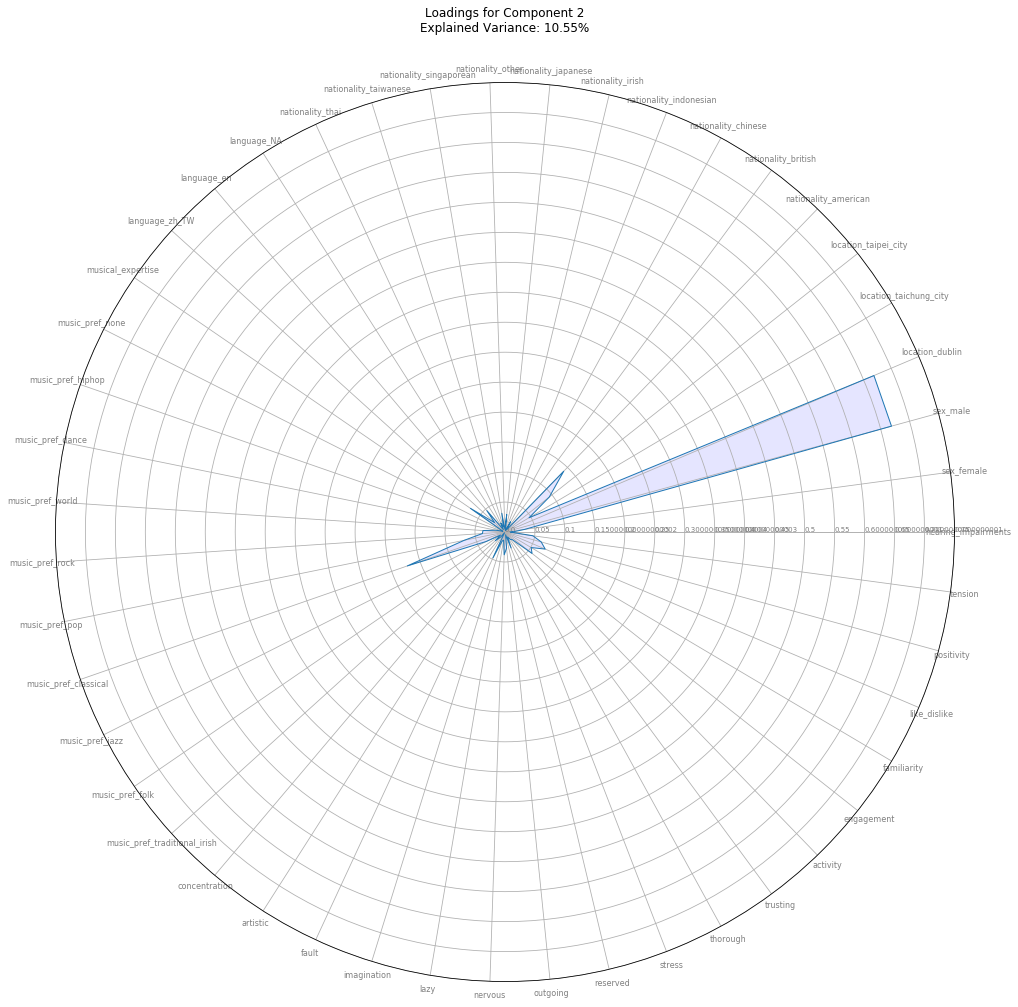

In [21]:
plot_component(pca_df.T, 2, pca.explained_variance_ratio_)

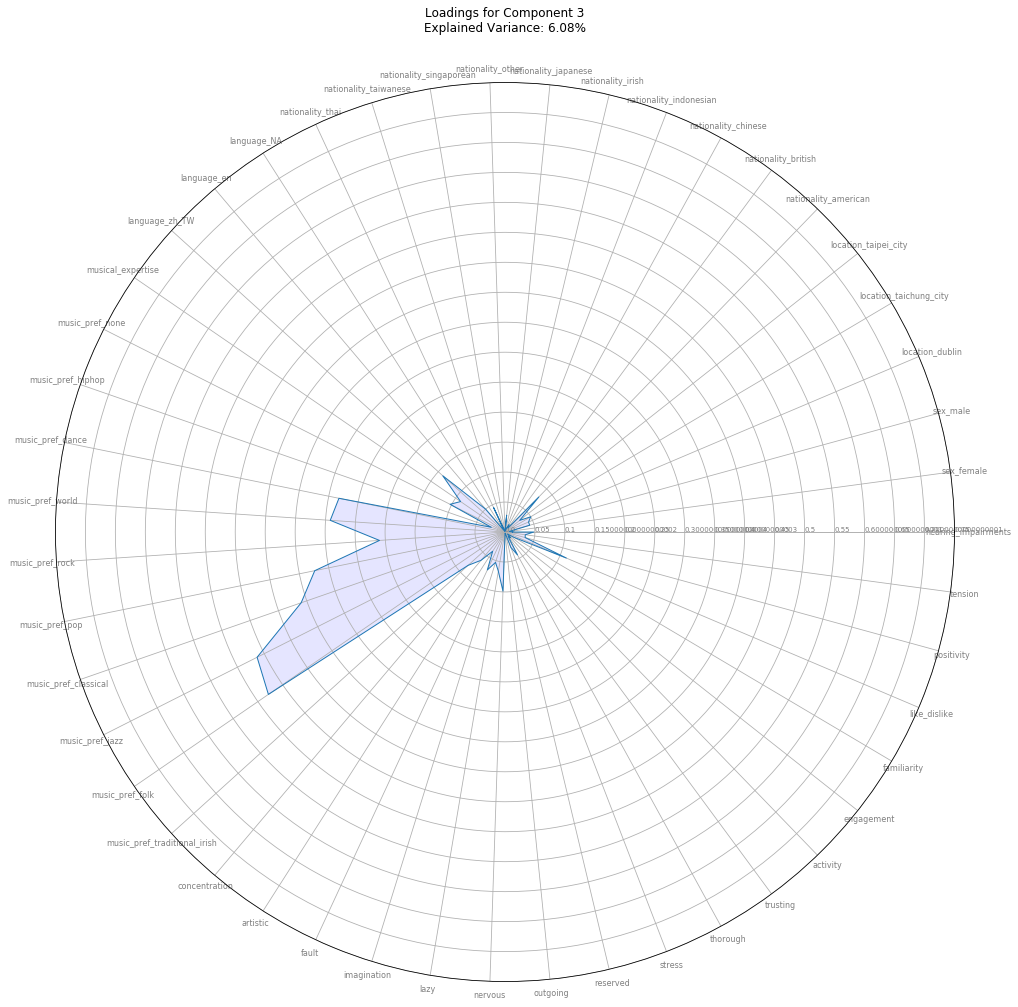

In [22]:
plot_component(pca_df.T, 3, pca.explained_variance_ratio_)

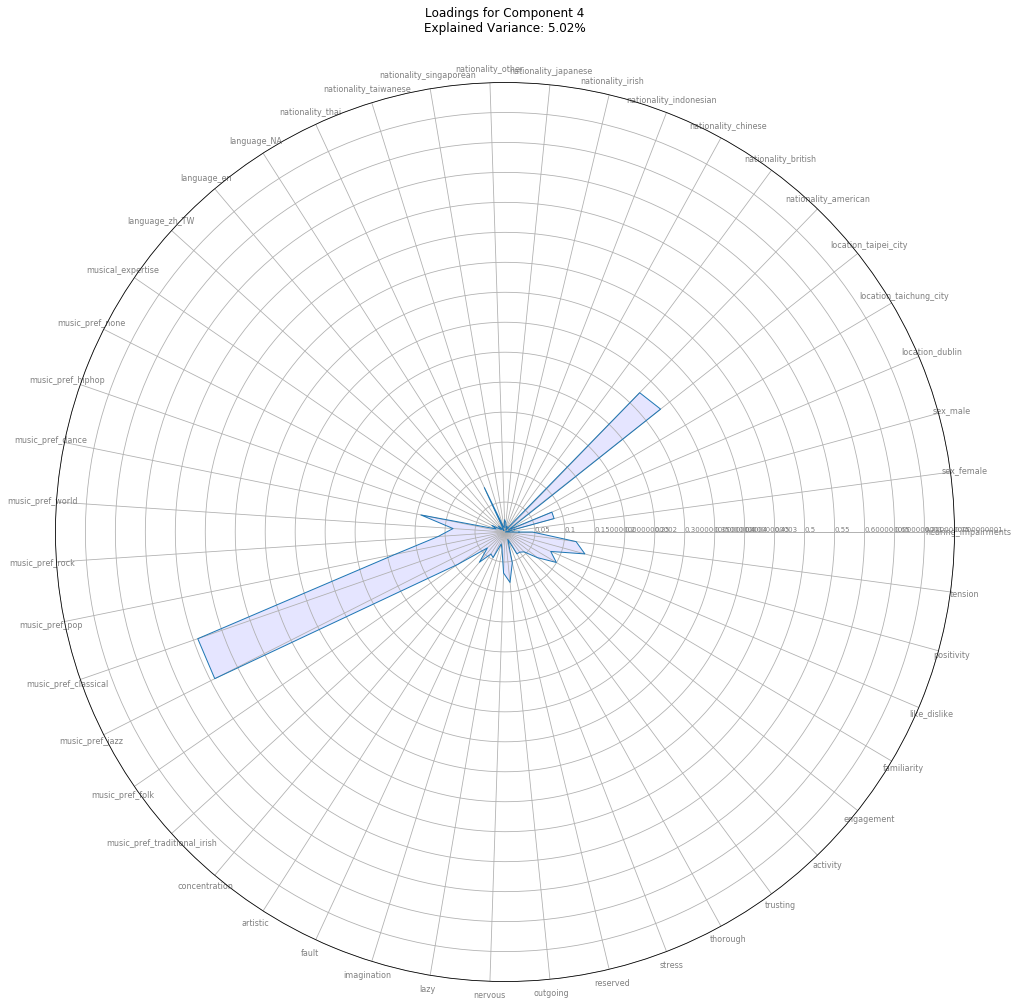

In [23]:
plot_component(pca_df.T, 4, pca.explained_variance_ratio_)

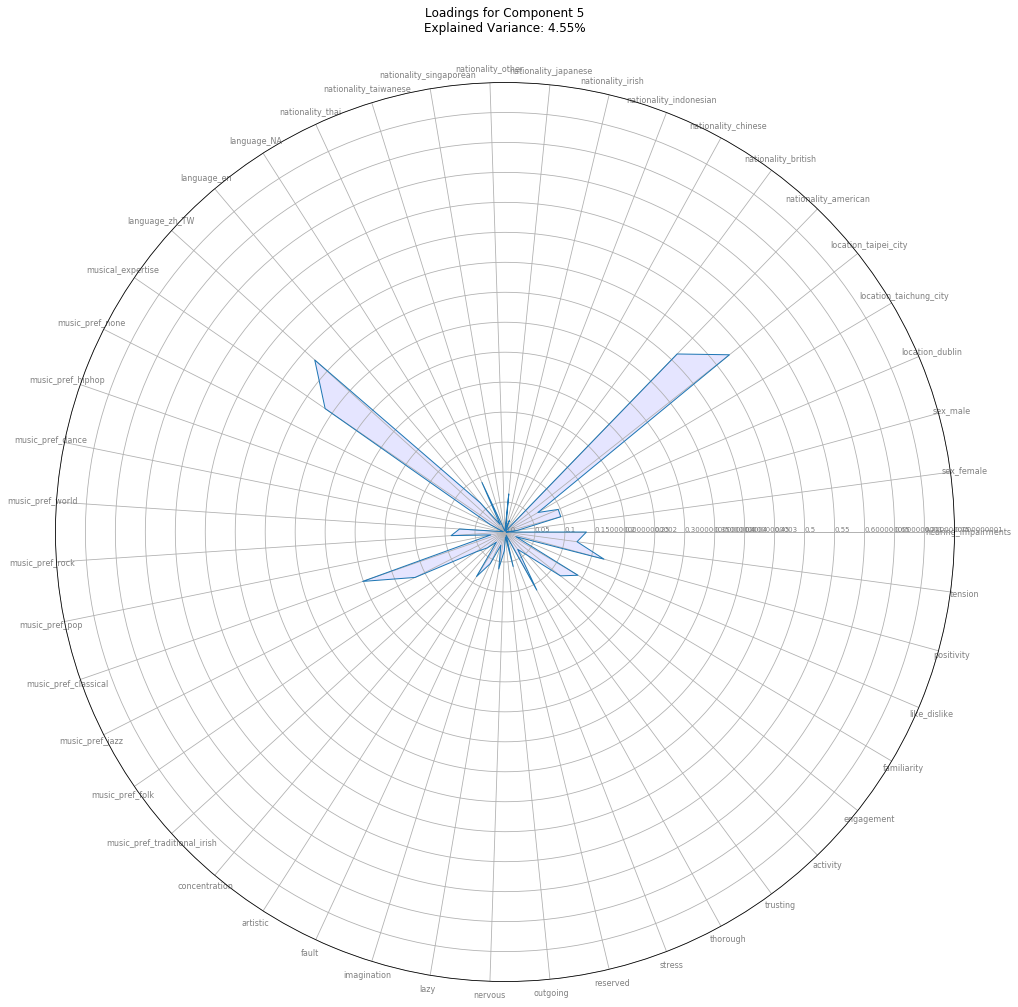

In [24]:
plot_component(pca_df.T, 5, pca.explained_variance_ratio_)

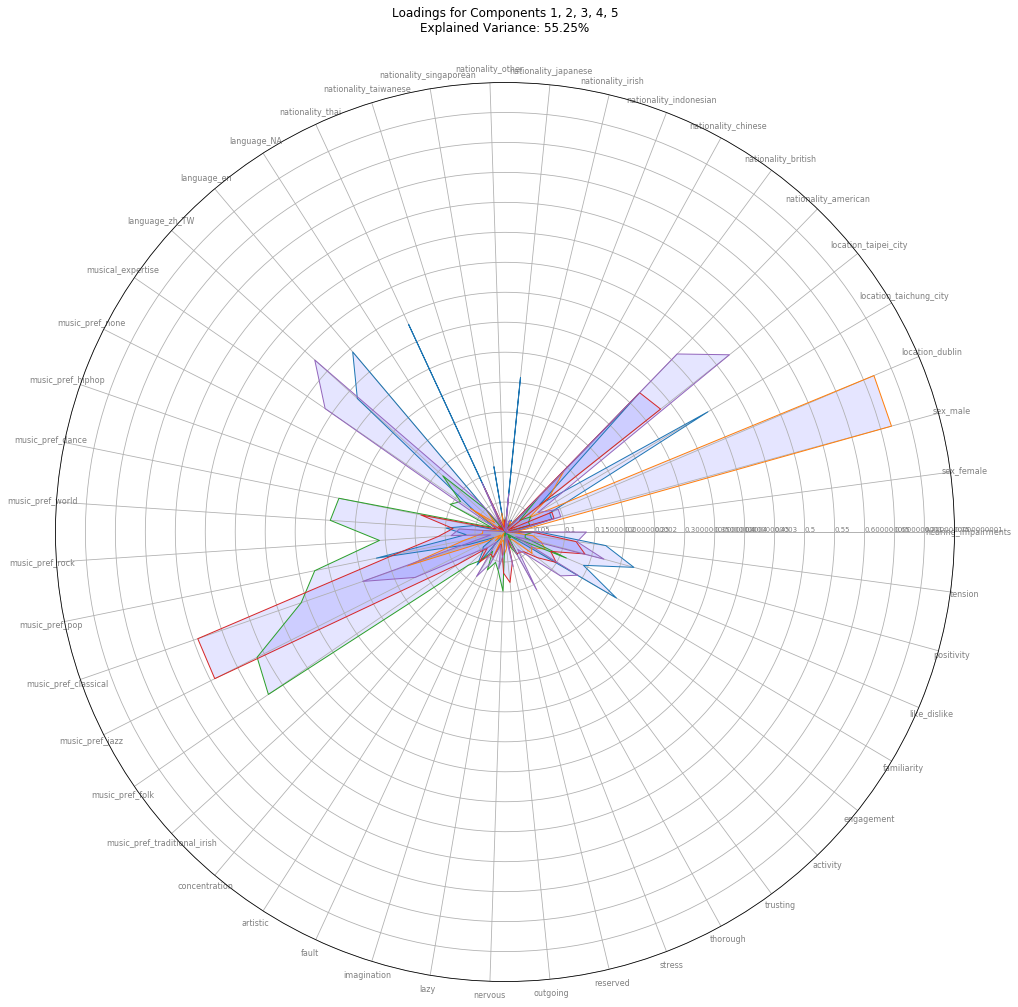

In [25]:
plot_component(pca_df.T, [1,2,3,4,5], pca.explained_variance_ratio_)

## Build / Evaluate Baseline Classifier
Construct a baseline classifier for comparison against our other classifiers. Because of class imbalance, this classifier predicts every example to be in the `False` class.

In [26]:
df_train_query = create_query(1, None)
df_train = client.query(df_train_query).to_dataframe()
df_train.describe()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,24.726073,3.993500,0.062706,2.547224,2.344099,3.175612,3.852643,3.690403,3.629726,3.213016,...,0.006601,0.138614,0.188119,0.132013,0.432343,0.673267,0.306931,0.171617,0.089109,0.059406
std,13.931034,0.795258,0.242835,1.009324,0.988361,0.891464,0.821620,0.905895,0.875898,0.961299,...,0.081110,0.346115,0.391454,0.339065,0.496221,0.469794,0.461983,0.377671,0.285372,0.236774
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,3.991266,0.000000,2.000000,2.000000,3.000000,3.824561,3.659389,3.596491,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,0.000000,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,4.000000,0.000000,3.000000,2.353712,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,121.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_eval_query = create_query(2, None)
df_eval = client.query(df_eval_query).to_dataframe()
df_eval.describe()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,24.016393,3.980170,0.049180,2.443733,2.401460,2.991372,3.685073,3.505333,3.431406,3.302847,...,0.016393,0.114754,0.213115,0.147541,0.409836,0.704918,0.327869,0.213115,0.049180,0.065574
std,11.491289,0.805997,0.218039,0.985933,0.828365,0.861184,0.910025,0.947435,0.848395,0.881794,...,0.128037,0.321370,0.412907,0.357588,0.495885,0.459865,0.473333,0.412907,0.218039,0.249590
min,5.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,3.991266,0.000000,2.000000,2.000000,3.000000,3.824561,3.659389,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,0.000000,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,4.000000,0.000000,3.000000,3.000000,3.144737,4.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,56.000000,5.000000,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Preprocess the training and evaluation dataframes.

In [28]:
# First, preprocess the training set and save the scaling_dict
df_train_X, df_train_scaling_dict = preprocess_df(df_train)
df_train_y = df_train['hallelujah_reaction']

# Now, preprocess the evaluation set, but use the same scaling parameters
# that were calculated for the training set
df_eval_X, _ = preprocess_df(df_eval, scaling_dict=df_train_scaling_dict)
df_eval_y = df_eval['hallelujah_reaction']

# Remove columns from training data that do not exist in eval data
all_columns = list(set(list(df_train_X.columns) + list(df_eval_X.columns)))
good_columns = [column for column in all_columns if column in df_train_X.columns and column in df_eval_X.columns]
df_train_X = df_train_X[good_columns]
df_eval_X = df_eval_X[good_columns]

Create a helper function to print classifier results.

In [29]:
def print_classifier_results(classifier, df_eval_X, df_eval_y):
    from sklearn import metrics
    
    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier.predict(df_eval_X)
    eval_probs = classifier.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # Print results for best classifier
    print('Results for baseline classifier:')
    print('\n')
    print('Overall F1 score: {}'.format(f1))
    print('True positives: {}'.format(tp))
    print('True negatives: {}'.format(tn))
    print('False positives: {}'.format(fp))
    print('False negatives: {}'.format(fn))
    print('\n')
    print(report)

    # Plot ROC curve for best classifier
    lw = 2
    figure = plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (RBF Kernel)')
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Plot precision-recall curve for best classifier
    figure = plt.figure(figsize=(12,8))
    plt.step(recall, precision, where='post', lw=lw)
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (RBF Kernel)'.format(average_precision))
    plt.tight_layout()

Create a helper function to generate a baseline classifier.

In [30]:
def get_baseline_classifier(df_train_X, df_train_y, constant):

    from sklearn.dummy import DummyClassifier

    classifier_baseline = DummyClassifier(strategy='constant', random_state=RANDOM_STATE, constant=constant)
    classifier_baseline = classifier_baseline.fit(df_train_X, df_train_y)
    
    return classifier_baseline

Build and evaluate a baseline classifier that always labels examples as "no reaction".

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Results for baseline classifier:


Overall F1 score: 0.0
True positives: 0
True negatives: 41
False positives: 0
False negatives: 20


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        41
           1       0.00      0.00      0.00        20

   micro avg       0.67      0.67      0.67        61
   macro avg       0.34      0.50      0.40        61
weighted avg       0.45      0.67      0.54        61



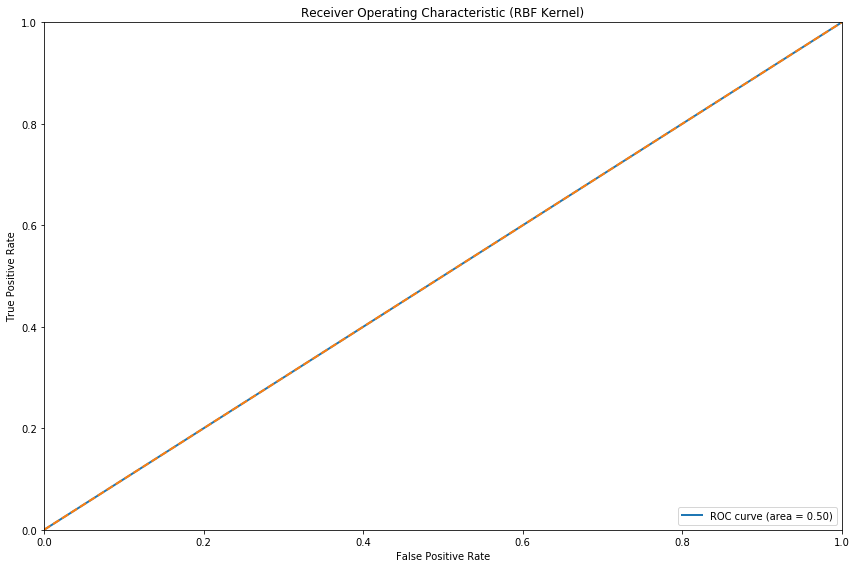

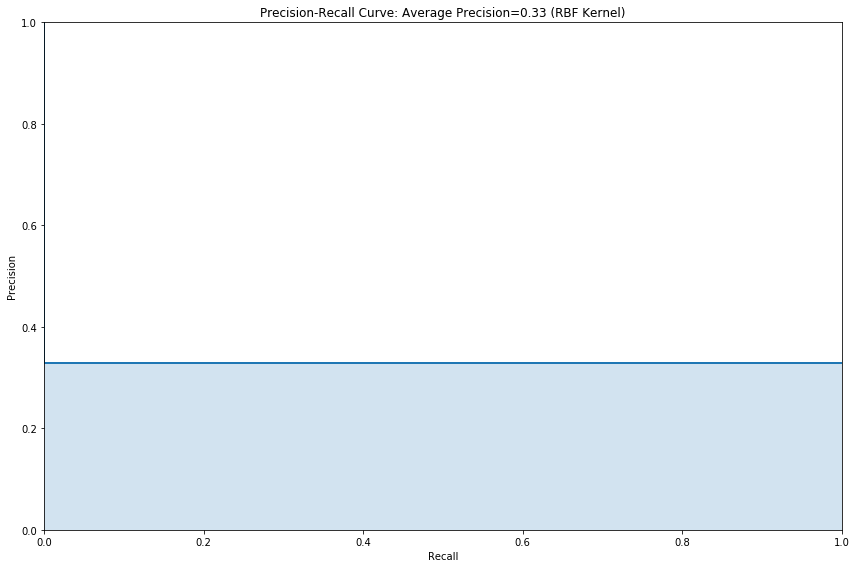

In [31]:
classifier_baseline_false = get_baseline_classifier(df_train_X, df_train_y, False)
print_classifier_results(classifier_baseline_false, df_eval_X, df_eval_y)

Build and evaluate a baseline classifier that always labels examples as "reaction".

/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20

Results for baseline classifier:


Overall F1 score: 0.49382716049382713
True positives: 20
True negatives: 0
False positives: 41
False negatives: 0


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.33      1.00      0.49        20

   micro avg       0.33      0.33      0.33        61
   macro avg       0.16      0.50      0.25        61
weighted avg       0.11      0.33      0.16        61



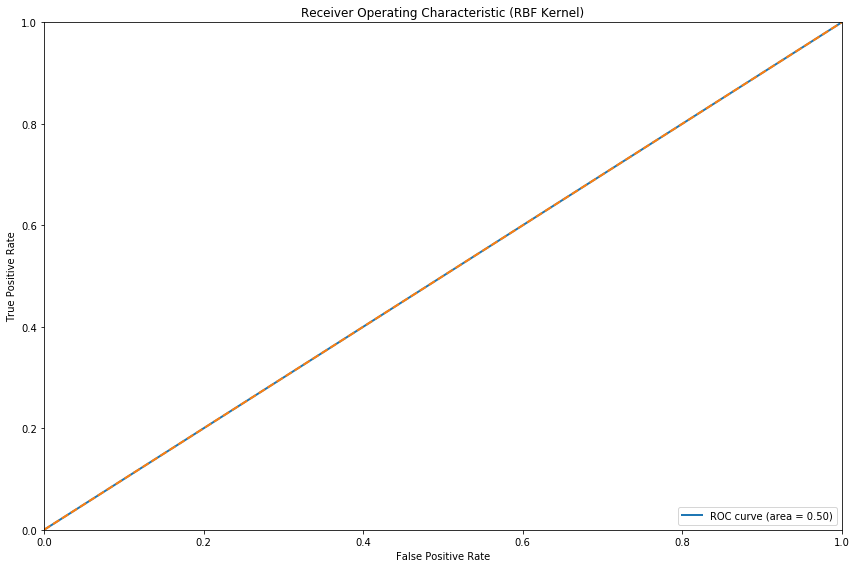

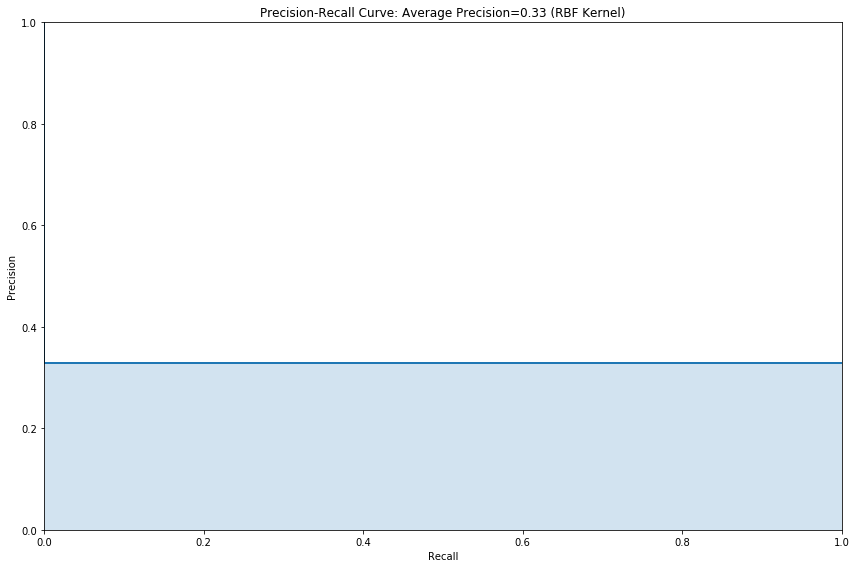

In [32]:
classifier_baseline_true = get_baseline_classifier(df_train_X, df_train_y, True)
print_classifier_results(classifier_baseline_true, df_eval_X, df_eval_y)